<a href="https://colab.research.google.com/github/Jyoti200/Customer-support-tickets-classification/blob/main/Topic_Modeling_for_customer_support_tickets_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Preparation:**

1.Load the provided .json data containing the customer complaints.
2.Preprocess the text data by cleaning and tokenizing the complaints. This may involve removing stop words, punctuation, and performing stemming or lemmatization.

**Topic Modeling using NMF:**

1.Convert the text data into a term-document matrix using TF-IDF (Term Frequency-Inverse Document Frequency).
2.Apply Non-Negative Matrix Factorization (NMF) to identify latent topics in the data. NMF will factorize the term-document matrix into two matrices: one representing topics and the other representing the contribution of each topic to each document.

**Determine Topics and Map to Clusters**:

1. Analyze the top words in each topic to understand the underlying themes.
2. Map each topic to one of the predefined clusters: Credit card / Prepaid card, Bank account services, Theft/Dispute reporting, Mortgages/loans, and Others.

**Classify Tickets:**

1. Assign each complaint ticket to the cluster corresponding to the highest contributing topic.

**Supervised Model Training:**

1. Use the labeled data obtained from the topic modeling step to train a supervised model.
2. Split the data into training and testing sets.
3. Train models such as logistic regression, decision tree, or random forest on the training set and deep learning.
4. Evaluate the performance of the models using the testing set.


In [1]:
# Importing Necessary Libraries
import numpy as np
import pandas as pd
import re,nltk,spacy,string
import en_core_web_sm
nlp=en_core_web_sm.load()
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [2]:
# Opening json file
data=json.load(open('/content/drive/MyDrive/ticket_complaints.json'))

In [3]:
df=pd.json_normalize(data)

In [4]:
df.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [ ]:
df['_type'].nunique()

1

In [ ]:
df.shape

(78313, 22)

In [ ]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [5]:
#Assign new column names
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product',]]
df.head()

,_source.complaint_what_happened,_source.product,_source.sub_product
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [6]:
# lets rename the column names to be more read friendly
# we have retained product and sub_product only for verification purpose ,
# these columns will not be used in the Topic modelling
df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})
df.head()

,complaint_text,category,sub_category
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [7]:
# lets merge the category and sub-category this will help us in deciding the topics after NMF modelling
df['category']=df['category'] + '+' + df['sub_category']
df.drop(['sub_category'],axis=1,inplace=True)
df.head(5)

,complaint_text,category
0,,Debt collection+Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...
3,,Mortgage+Conventional home mortgage
4,,Credit card or prepaid card+General-purpose cr...


In [ ]:
df['complaint_text'].isna().sum()

0

In [ ]:
len(df[df['complaint_text']==''])

57241

In [8]:
df[df['complaint_text']==''] = np.nan
df.complaint_text.isnull().sum()

57241

In [9]:
#Remove all rows where complaints column is nan
# Lets drop all the rows where complaint_text is null
df = df[~df['complaint_text'].isnull()]
df.complaint_text.isnull().sum()

0

In [10]:
# Preparing text for Topic modelling
def prepare_text(text):
  text=text.lower()
  text=re.sub('\[.*\]','',text).strip()  #removing square brackets text
  text=text.translate(str.maketrans('', '', string.punctuation)) #remove punctuation
  text=re.sub('\S*\d\S*\s*','', text).strip()
  return text.strip()

In [11]:
df.complaint_text = df.complaint_text.apply(lambda x: prepare_text(x))
df.complaint_text.head()

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in and was told b...
10    chase card was reported on however fraudulent ...
11    on while trying to book a xxxx  xxxx  ticket i...
14    my grand son give me check for i deposit it in...
Name: complaint_text, dtype: object

**Data lemmatizer**

The goal of lemmatization is to reduce a word to its root form, also called a lemma. For example, the verb "running" would be identified as "run." Lemmatization studies the morphological, or structural, and contextual analysis of words.



In [12]:
stopwords = nlp.Defaults.stop_words
def lemmatizer(text):
    doc = nlp(text)
    sent = [token.lemma_ for token in doc if not token.text in set(stopwords)]
    return ' '.join(sent)

In [13]:
df['lemma'] =  df.complaint_text.apply(lambda x: lemmatizer(x))
df.head()

,complaint_text,category,lemma
1,good morning my name is xxxx xxxx and i apprec...,Debt collection+Credit card debt,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told b...,Credit card or prepaid card+General-purpose cr...,upgrade xxxx xxxx card tell agent upgrade anni...
10,chase card was reported on however fraudulent ...,"Credit reporting, credit repair services, or o...",chase card report fraudulent application submi...
11,on while trying to book a xxxx xxxx ticket i...,"Credit reporting, credit repair services, or o...",try book xxxx xxxx ticket come offer apply...
14,my grand son give me check for i deposit it in...,Checking or savings account+Checking account,grand son check deposit chase account fund cle...


In [15]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = df[['complaint_text','lemma','category']]
df_clean.head()

,complaint_text,lemma,category
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o..."
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o..."
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account


**Data POS Tag Extraction**

Part-of-speech (POS) tagging is a natural language processing (NLP) technique that automatically assigns each word in a text a part of speech, such as a noun, verb, or adjective. POS tagging can be used to extract specific information from a text, such as names, locations, and organizations.

In [16]:
def pos_extractor(text):
  doc=nlp(text)
  sent = [token.text for token in doc if token.tag_=='NN']
  return ' '.join(sent)

In [17]:
df_clean['complaint_POS_removed']=df_clean.lemma.apply(pos_extractor)
df_clean.head(3)

,complaint_text,lemma,category,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help bank service chase debt verificat...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date change age...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...


# **Exploratory Data Analysis**

(array([9.236e+03, 6.356e+03, 2.725e+03, 1.276e+03, 7.570e+02, 2.750e+02,
        1.500e+02, 7.100e+01, 6.300e+01, 3.900e+01, 3.700e+01, 1.300e+01,
        1.100e+01, 1.100e+01, 8.000e+00, 8.000e+00, 7.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 7.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([    0. ,   248.5,   497. ,   745.5,   994. ,  1242.5,  1491. ,
         1739.5,  1988. ,  2236.5,  2485. ,  2733.5,  2982. ,  3230.5,
         3479. ,  3727.5,  3976. ,  4224.5,  4473. ,  4721.5,  4970. ,
         5218.5,  5467. ,  5715.5,  5964. ,  6212.5,  6461. ,  6709.5,
         6958. ,  7206.5,  7455. ,  7703.5,  7952. ,  8200.5,  8449. ,
         8697.5,  894

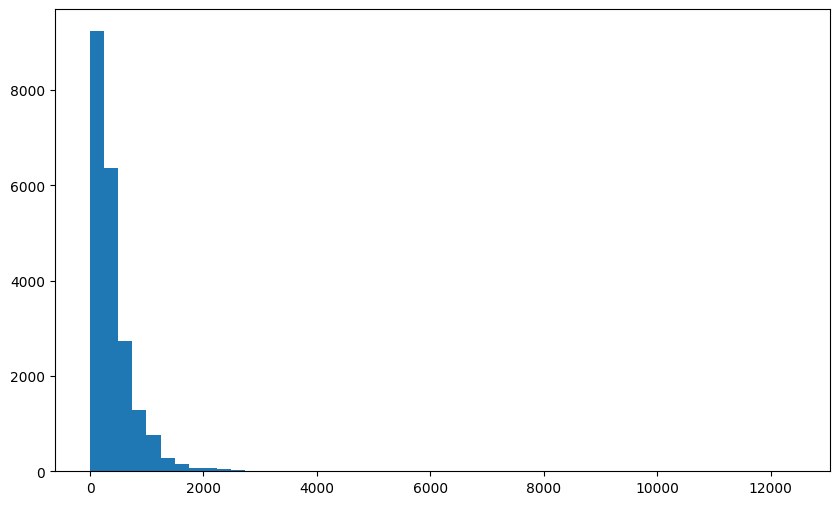

In [16]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)

#### **Find the top 40 words by frequency among all the articles after processing the text.**

In [ ]:
!pip install wordcloud

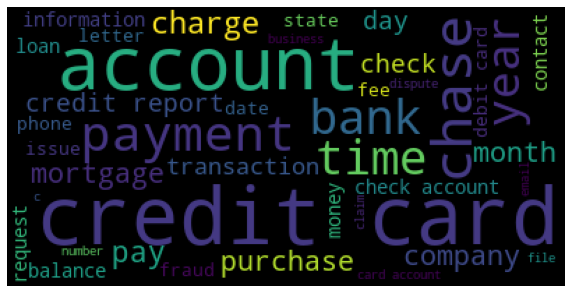

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=stopwords,max_words=40).generate(str(df_clean.complaint_POS_removed))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [18]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean = df_clean.drop(['complaint_POS_removed'],axis = 1)

<p style="background-color: #6700c0; font-family: Franklin Gothic Medium; color: #FFF9ED; font-size: 250%; text-align: center; border-radius: 10px;">
  <a id="top_uni_bi_trigram" style="color: white; text-decoration: none;">Finding the Top Unigrams, Bigrams and Trigrams</a>
</p>


In [19]:
def get_top_n_bigram(text,ngram=1,top=None):
  vec=CountVectorizer(ngram_range=(ngram,ngram),stop_words='english').fit(text)
  bag_of_words=vec.transform(text)

  sum_words = bag_of_words.sum(axis=0)
  words_freq=[(word, sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]

  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:top]

In [20]:
top_30_unigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=1, top=30)
top_30_bigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=2, top=30)
top_30_trigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=3, top=30)

In [21]:
#Print the top 10 words in the unigram frequency
print('Top 10 unigrams:\n')
top_30_unigrams[:10]

Top 10 unigrams:



[('chase', 53419),
 ('account', 40961),
 ('credit', 33554),
 ('xxxx', 31291),
 ('card', 29835),
 ('payment', 21064),
 ('bank', 17038),
 ('time', 15871),
 ('charge', 15292),
 ('day', 12831)]

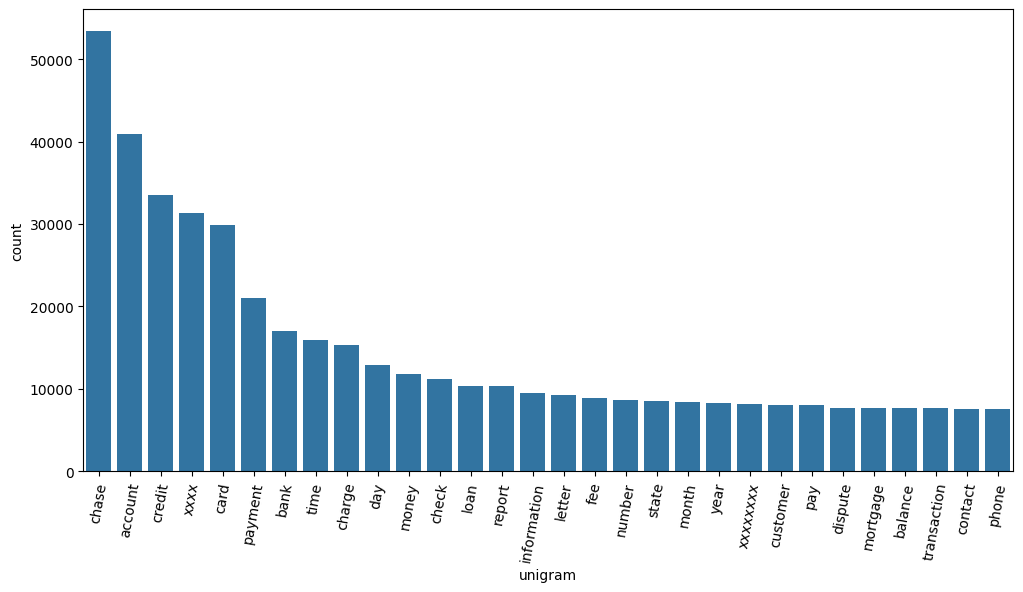

In [ ]:
#Plot graph for the top 30 words in the unigram frequency
df1 = pd.DataFrame(top_30_unigrams, columns = ['unigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df1['unigram'], y=df1['count'])
plt.xticks(rotation = 80)
plt.show()

In [ ]:
#Print the top 10 words in the bigram frequency
print('Top 10 bigrams:\n')
top_30_bigrams[:10]

Top 10 bigrams:



[('credit card', 12773),
 ('credit report', 3893),
 ('chase credit', 3070),
 ('customer service', 2923),
 ('account chase', 2432),
 ('chase bank', 2120),
 ('check account', 2113),
 ('chase account', 2034),
 ('xxxx xxxx', 1954),
 ('contact chase', 1893)]

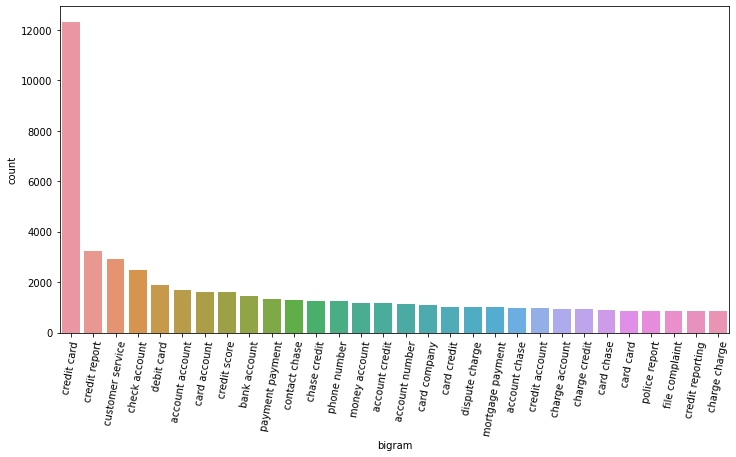

In [ ]:
#Plot graph for the top 30 words in the bigram frequency
df2 = pd.DataFrame(top_30_bigrams, columns = ['bigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df2['bigram'], y=df2['count'])
plt.xticks(rotation = 80)
plt.show()

In [ ]:
#Print the top 10 words in the trigram frequency
print('Top 10 trigrams:\n')
top_30_trigrams[:10]

Top 10 trigrams:



[('credit card account', 1038),
 ('credit card company', 980),
 ('chase credit card', 870),
 ('charge credit card', 583),
 ('credit card credit', 500),
 ('credit card chase', 449),
 ('inquiry credit report', 443),
 ('card credit card', 412),
 ('account credit card', 396),
 ('file police report', 356)]

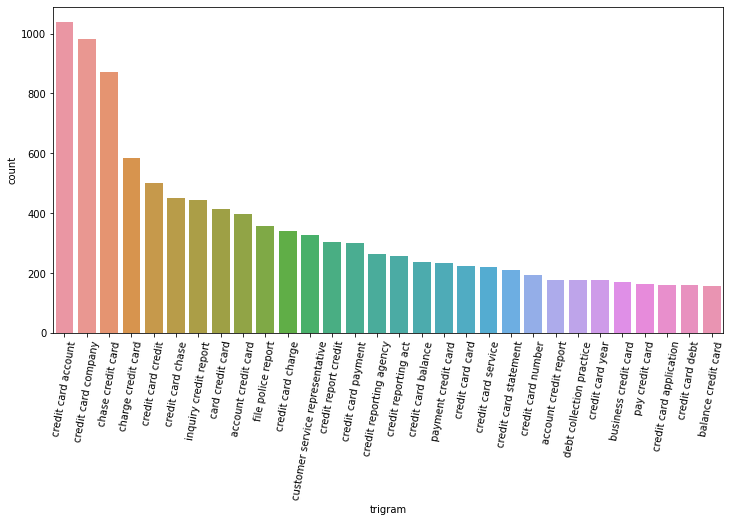

In [ ]:
#Plot graph for the top 30 words in the trigram frequency
df3 = pd.DataFrame(top_30_trigrams, columns = ['trigram' , 'count'])
plt.figure(figsize=(12,6))
fig = sns.barplot(x=df3['trigram'], y=df3['count'])
plt.xticks(rotation = 80)
plt.show()

#### **The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis**

In [22]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [23]:
#All masked texts has been removed
df_clean.head()

,complaint_text,lemma,category,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help bank service chase debt verificat...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date change age...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o...",book ticket come offer ticket reward card info...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,son deposit chase account fund bank account pa...


# **Feature Extraction**

**Convert the raw texts to a matrix of TF-IDF features**

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words" max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [24]:
# initialise the tfidf vectorizer
tfidf= TfidfVectorizer(min_df=2, max_df=0.95, stop_words ='english')

**Document Term Matrix**

A document-term matrix is a mathematical matrix that describes the frequency of terms that occur in each document in a collection. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms.

In [25]:
#Creating the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.Complaint_clean)

## **Topic Modelling using NMF**

- ### **Non-Negative Matrix Factorization (NMF)**
It is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

- In this task we are performing the following:

 * Find the best number of clusters
 * Apply the best number to create word clusters
 * Inspect & validate the correction of each cluster wrt the complaints
 * Correct the labels if needed
 * Map the clusters to topics/cluster names

In [26]:
from sklearn.decomposition import NMF

## **Manual Topic Modeling**
 - We need to do take the trial & error approach to find the best num of topics for NMF model.

 - The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good final topics are.

In [27]:
num_topics =  5

nmf_model = NMF(n_components=num_topics, random_state=40)

W1 = nmf_model.fit_transform(dtm)
H1 = nmf_model.components_

In [28]:
#Print the Top15 words for each of the topics
num_words=15

vocab = np.array(tfidf.get_feature_names_out())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [29]:
vocab

array(['aarp', 'abandonment', 'abatement', ..., 'zombie', 'zone', 'zoom'],
      dtype=object)

In [25]:
topics
# Credit card / Prepaid card - 1
# Bank account services - 0
# Theft/Dispute reporting - 3
# Mortgages/loans - 4
# Others - 2

['account check money bank deposit chase fund day branch transfer number business transaction customer claim',
 'card credit chase balance account score limit year purchase point month application service reason time',
 'payment loan mortgage chase month modification time home pay year rate balance property statement date',
 'report inquiry credit information company reporting debt account file identity remove dispute theft score letter',
 'charge dispute fee chase transaction merchant claim purchase refund fraud service email time contact statement']

In [30]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(df_clean.Complaint_clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.03,0.00,0.02,0.02,0.01,0
Doc1,0.01,0.02,0.00,0.00,0.01,1
Doc2,0.00,0.03,0.00,0.04,0.00,3
Doc3,0.02,0.03,0.01,0.05,0.01,3
Doc4,0.07,0.00,0.01,0.00,0.00,0


In [31]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = significant_topic

In [32]:
pd.set_option('display.max_colwidth', 0)

In [33]:
df_clean[['complaint_text','Complaint_clean','category','Topic']][df_clean.Topic==4].head(30)

,complaint_text,Complaint_clean,category,Topic
21,on xxxx i made a payment to an online retailer using chase quick pay with xxxx on the chase website i realized that this was a scam website after no confirmation product or response to any inquiries regarding the order and contacted chase to get more information about the transaction to attempt getting a refund through the retailers bank \n\ni contacted chase via a secured message on explaining what happened and asked is there a way to reverse this transaction or do you have a contact at xxxx that can give me more information about the recipient that xxxx my message was reviewed and i received a response restating my original email and informing me that the transfer has been completed however as you mentioned that the website is a scam while we can handle most inquiries by email some require the expertise of another team in order to assist you better in regards to the refund we request you to call our consumer online technical support team i called the number listed in the email and explained my situation to then be transferred to the claims department i was directed to call xxxx and ask them about the transaction because chase did not have any information outside of what i provided when initiating the transfer i felt like this agent was trying to get me to end the call as quickly as possible and i had to interrupt her closing script to ask for a contact number at xxxx and didnt have an opportunity to get any information about what the right questions would be to ask xxxx or what words and phrases i should use to get the information i was looking for \n\ni called xxxx whos automated system initially directed me to call my bank because i used the banks app to initiate the transaction i called xxxx again to navigate their menus and talk to a customer service agent they told me that all of the information about the transaction would in chase s system because i used the banks app to perform the transaction she stayed on the line with me until i understood everything that i should ask and had a better understanding of the situation i ended the call and called chase again \n\nwhen i called chase the second time the agent tried to look up the information about the receiving bank but could not find any additional information she then asked me why i needed this information and i explained my situation again i was once again transferred to the claims department who told me that i needed to contact xxxx to get the information i was looking for after i told her that i had already contacted them she finally admitted that there was nothing that she could do due to the nature of the transaction and that these types of transactions are not secured she said that chase had no information about the recipient other than the email address that i inputted and that the recipients banking information was not kept in the system in both phone calls they asked if i initiated that transaction and used that to absolve themselves of all responsibility in regards to this matter \n\nduring this whole process it felt like chase was not transparent about their policies regarding these types of transactions nor were they helpful in helping me get any information about the situation these transactions are advertised as a fast safe and easy way to send money but seem to be a dangerous way to do business i feel deceived by chase s advertising and further victimized by the way i was treated by the members on their customer service team,payment retailer chase pay website scam website confirmation product response inquiry order contact chase information transaction attempt retailer bank contact chase message way transaction contact information recipient message review response email transfer mention website scam inquiry email expertise team order request consumer support team number list email situation transfer claim transaction chase information initiate transfer agent try closing script contact number opportunity i

In [34]:
# Print the first 10 Complaint for each of the Topics
temp =df_clean[['complaint_text','Complaint_clean','category','Topic']].groupby('Topic').head(10)
temp.sort_values('Topic')

,complaint_text,Complaint_clean,category,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,Debt collection+Credit card debt,0
69,someone called stating i had felony committed under my social security number and name took xxxx out of my checking account to secure my assets stating from police department,state felony security number check account asset state police department,Checking or savings account+Checking account,0
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,son deposit chase account fund bank account pay money speek son money bank money son call chase time check owner country time date check number claim number chase,Checking or savings account+Checking account,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally thank you,account debit card branch customer service representative account branch remove fund deposit place employm

#### **After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:**
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [35]:
#Create the dictionary of Topic names and Topics
topic_mapping = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_mapping)

#### **Lets check if there is any class imbalance**

<Axes: xlabel='Topic', ylabel='count'>

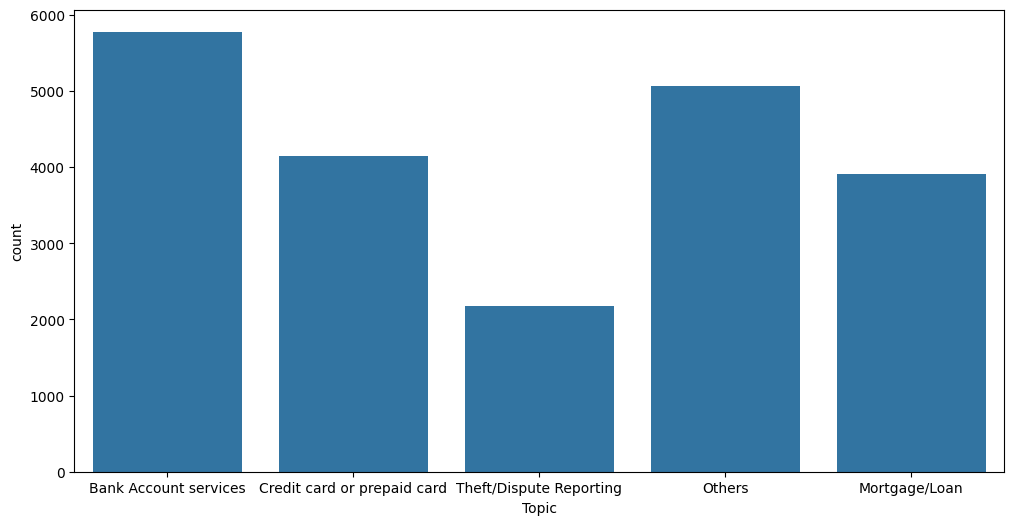

In [36]:
# Plot graph to check class imbalance
plt.figure(figsize=(12,6))
sns.countplot(x='Topic',data=df_clean)

# **Model building using supervised learning, Model training & evaluation**



## **Supervised model to predict any new complaints to the relevant Topics.**

- We now build the model to create the topics for each complaints.

- Since we will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [37]:
training_data = df_clean[['complaint_text','Topic']]

In [38]:
training_data.head()

,complaint_text,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,Bank Account services
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,Credit card or prepaid card
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,Theft/Dispute Reporting
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,Theft/Dispute Reporting
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,Bank Account services


## **Reverse topic names mapping for supervised learning**

In [39]:
## Reverse topic names mapping for supervised learning

reverse_topic_mapping = {
    'Bank Account services' :0,
    'Credit card or prepaid card':1,
    'Others':2,
    'Theft/Dispute Reporting':3,
    'Mortgage/Loan':4
}
#Replace Topics with Topic Names
training_data['Topic'] = training_data['Topic'].map(reverse_topic_mapping)
training_data.head()

,complaint_text,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,3
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,3
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,0


In [41]:
training_data[['complaint_text','Topic']][training_data.Topic==3].head(30)

,complaint_text,Topic
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,3
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,3
15,can you please remove inquiry,3
26,i have reached out to xxxx several times in attempt to have this fraudulent inquiry removed i was told that i need to call and contact the original creditor that placed this inquiry on my report i have made several attempts to get chase bank to contact the bureau and remove this inquiry that was not authorized by me they seem to not be able to get me to the right person to take care of this issue no matter how many attempts i have made nobody seems to understand what im talkin about i want chase bank to have this fraudulent inquiry removed from my credit report before i take legal action i i have never requested any kind of credit with chase bank or hold any account with them i have an iquiry from i want this matter resolved,3
83,unknown inquire reported on my credit bureau such as xxxx and xxxx date of company chase auto,3
100,i have contacted both chase bank and xxxx xxxx about credit inquiries which i did not initiate \nboth companies assured me they would correct these inaccuracies in reviewing my credit reports with xxxx amd xxxx none of the companies involved have done so \nxxxx xxxxxxxx and xxxx xxxx xxxx xxxx xxxxxxxx i have not applied for credit for over two years,3
135,i checked my credit reports and noticed the inquiry on there but have not done any business with this company they will not remove it,3
139,chase im filing a complaint after disputing with all three reporting company times and they are not fixing my problem so i have started lawsuits on all three so now im disputing direct with you i found a lot of fcra violation on account xxxx first violation is fcra b you are not entering the consumer dispute marks on none of the reports after you have verified this account the law states that a creditor must must enter this information because it can not report on the consumer report this is a violation of the fcra you could be sued per bureau violation number two you stated that this account has been closed but you are still reporting a monthly payment this is also a violation of the fcra another per bureau so please delete this account asap due to the violation of the fcra the law is very clear as to the civil liability and the remedy available to me if you fail to comply with federal law i am a litigious consumer and fully intend on pursui

#### **Apply the supervised models on the training data created. In this process, you have to do the following:**
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


## **X - Y split**

In [42]:
# x - y  split
X = training_data.complaint_text
y = training_data.Topic

In [43]:
# Fit transform the X
count_vect = CountVectorizer()
X_vect = count_vect.fit_transform(X)

In [44]:
from sklearn.feature_extraction.text import TfidfTransformer
#Fit transform word vector to TF-IDF
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_vect)


**Train Test Split**

In [45]:
from sklearn.model_selection import train_test_split
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.20, random_state=40)

In [46]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## **Custom Classification Report**

In [47]:
# utlity function to display the model report

def display_classification_report(model,metric):

    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    roc_auc_score_train = round(roc_auc_score(y_train, y_train_pred_proba,average='weighted',multi_class='ovr'),2)
    roc_auc_score_test = round(roc_auc_score(y_test, y_test_pred_proba,average='weighted',multi_class='ovr'),2)
    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)
    metric.append(roc_auc_score_train)
    metric.append(roc_auc_score_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    precision_train,recall_train,fscore_train,support_train=precision_recall_fscore_support(y_train,y_train_pred,average='weighted')
    precision_test,recall_test,fscore_test,support_test=precision_recall_fscore_support(y_test,y_test_pred,average='weighted')

    acc_score_train = round(accuracy_score(y_train,y_train_pred),2)
    acc_score_test = round(accuracy_score(y_test,y_test_pred),2)

    metric.append(acc_score_train)
    metric.append(acc_score_test)
    metric.append(round(precision_train,2))
    metric.append(round(precision_test,2))
    metric.append(round(recall_train,2))
    metric.append(round(recall_test,2))
    metric.append(round(fscore_train,2))
    metric.append(round(fscore_test,2))

    print('Train Accuracy :',acc_score_train)
    print('Test Accuracy :',acc_score_test)

    model_report_train = classification_report(y_train,y_train_pred)
    model_report_test = classification_report(y_test,y_test_pred)

    print('Classification Report for Train:\n',model_report_train)
    print('Classification Report for Test:\n',model_report_test)


    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.xticks(rotation=80)

    plt.show();

## **Stratified KFold Cross Validation**

In [48]:
# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)

## **Custom GridSearchCV**

In [49]:
# utility method to get the GridSearchCV object
def grid_search(model,folds,params,scoring):

    grid_search = GridSearchCV(model,
                                cv=folds,
                                param_grid=params,
                                scoring=scoring,
                                verbose=1)
    return grid_search

In [50]:
# utility function to display the best score and parameters of the GridSearchCV model
def print_best_score_params(model):
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

## **Multinomial Naive Bayes Classification**

ROC AUC Score Train: 0.95
ROC AUC Score Test: 0.93
Train Accuracy : 0.68
Test Accuracy : 0.65
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.59      0.94      0.72      4279
           1       0.65      0.84      0.74      4054
           2       0.97      0.02      0.04      1766
           3       0.91      0.50      0.65      3026
           4       0.88      0.65      0.74      2679

    accuracy                           0.68     15804
   macro avg       0.80      0.59      0.58     15804
weighted avg       0.76      0.68      0.64     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.55      0.92      0.69      1426
           1       0.63      0.80      0.70      1351
           2       1.00      0.01      0.02       589
           3       0.88      0.44      0.58      1009
           4       0.87      0.62      0.72       893

    accuracy            

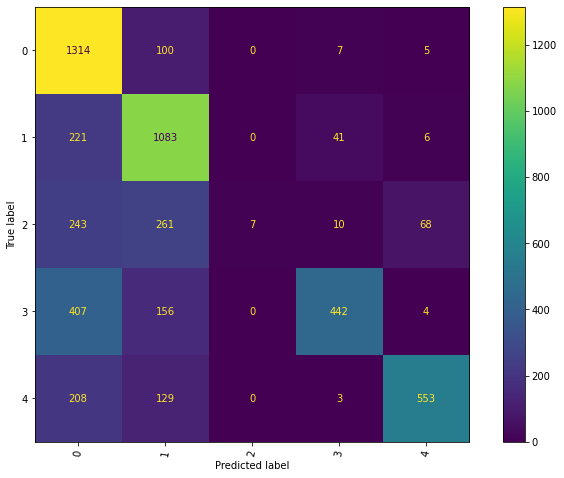

In [ ]:
# Multinomial Naive Bayes Classification

# create MNB model object
mnb = MultinomialNB()
# fit model
mnb.fit(X_train, y_train)
# display classification report
metric1=[]
display_classification_report(mnb,metric1)

<p style="background-color: #FF0068; font-family: Franklin Gothic Medium; color: #FFF9ED; font-size: 150%; text-align: center; border-radius: 10px;">
  <a id="logistic_regression_classification" style="color: white; text-decoration: none;">Logistic Regression Classification</a>
</p>


## **Logistic Regression Classification**

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.99
Train Accuracy : 0.94
Test Accuracy : 0.9
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      4279
           1       0.94      0.96      0.95      4054
           2       0.97      0.87      0.92      1766
           3       0.94      0.92      0.93      3026
           4       0.94      0.94      0.94      2679

    accuracy                           0.94     15804
   macro avg       0.94      0.93      0.94     15804
weighted avg       0.94      0.94      0.94     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      1426
           1       0.91      0.92      0.92      1351
           2       0.94      0.81      0.87       589
           3       0.91      0.87      0.89      1009
           4       0.90      0.92      0.91       893

    accuracy              

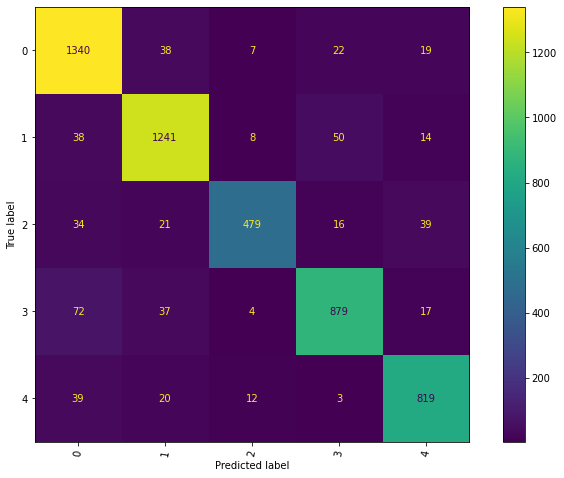

In [ ]:
# Logistic Regression Classification
log_reg = LogisticRegression(random_state=40,solver='liblinear')
# fit model
log_reg.fit(X_train,y_train)
# display classification report
metric2=[]
display_classification_report(log_reg,metric2)

<p style="background-color: #FF0068; font-family: Franklin Gothic Medium; color: #FFF9ED; font-size: 150%; text-align: center; border-radius: 10px;">
  <a id="decision_tree_classification" style="color: white; text-decoration: none;">Decision Tree Classification</a>
</p>


## **Decision Tree Classification**

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.85
Train Accuracy : 1.0
Test Accuracy : 0.77
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4279
           1       1.00      1.00      1.00      4054
           2       1.00      1.00      1.00      1766
           3       1.00      1.00      1.00      3026
           4       1.00      1.00      1.00      2679

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78      1426
           1       0.81      0.81      0.81      1351
           2       0.74      0.75      0.75       589
           3       0.72      0.72      0.72      1009
           4       0.78      0.78      0.78       893

    accuracy              

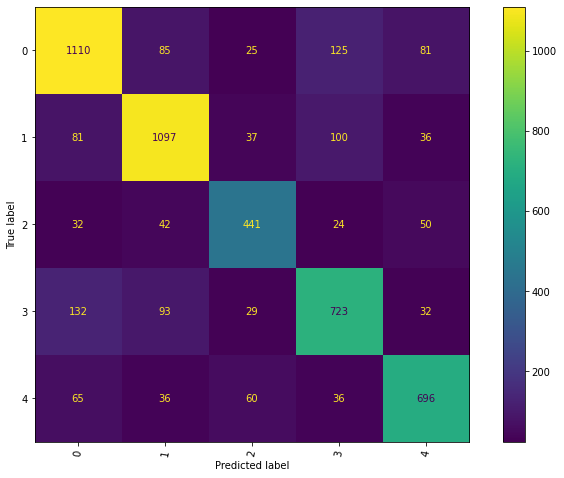

In [ ]:
# Decision Tree Classification
dtc = DecisionTreeClassifier(random_state=40)
# fit model
dtc.fit(X_train,y_train)
# Decision Tree Classification Report
metric3=[]
display_classification_report(dtc,metric3)

<p style="background-color: #FF0068; font-family: Franklin Gothic Medium; color: #FFF9ED; font-size: 150%; text-align: center; border-radius: 10px;">
  <a id="random_forest_classification" style="color: white; text-decoration: none;">Random Forest Classification</a>
</p>


## **Random Forest Classification**

OOB SCORE : 0.8015692229815237
ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.97
Train Accuracy : 1.0
Test Accuracy : 0.82
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4279
           1       1.00      1.00      1.00      4054
           2       1.00      1.00      1.00      1766
           3       1.00      1.00      1.00      3026
           4       1.00      1.00      1.00      2679

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.76      0.93      0.84      1426
           1       0.81      0.89      0.85      1351
           2       0.96      0.44      0.60       589
           3       0.86      0.75      0.80      1009
           4       0.84      0.85      0.85       

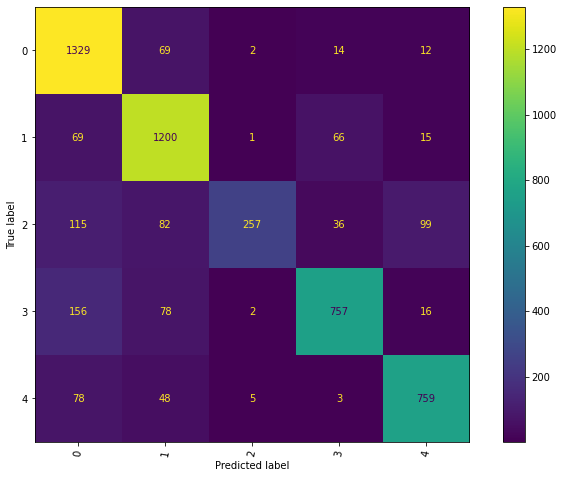

In [ ]:
# Random Forest Classification

rf = RandomForestClassifier(n_estimators = 500,random_state=40, n_jobs = -1,oob_score=True)
# fit model
rf.fit(X_train,y_train)

# oob score
print('OOB SCORE :',rf.oob_score_)

# Random Forest Classification Report
metric4=[]
display_classification_report(rf,metric4)

# **Hyper parameter tuning with GridSearchCV**

## **Logistic Regression with GridSearchCV**

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score:  0.9227026768336305
Best Hyperparameters:  {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.99
Train Accuracy : 0.94
Test Accuracy : 0.93
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      4629
           1       0.94      0.93      0.93      3323
           2       0.95      0.96      0.96      4065
           3       0.92      0.90      0.91      1741
           4       0.93      0.92      0.92      3099

    accuracy                           0.94     16857
   macro avg       0.94      0.93      0.93     16857
weighted avg       0.94      0.94      0.94     16857

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1147
           1       0.92      0.94      0.93       824
           2       0.95     

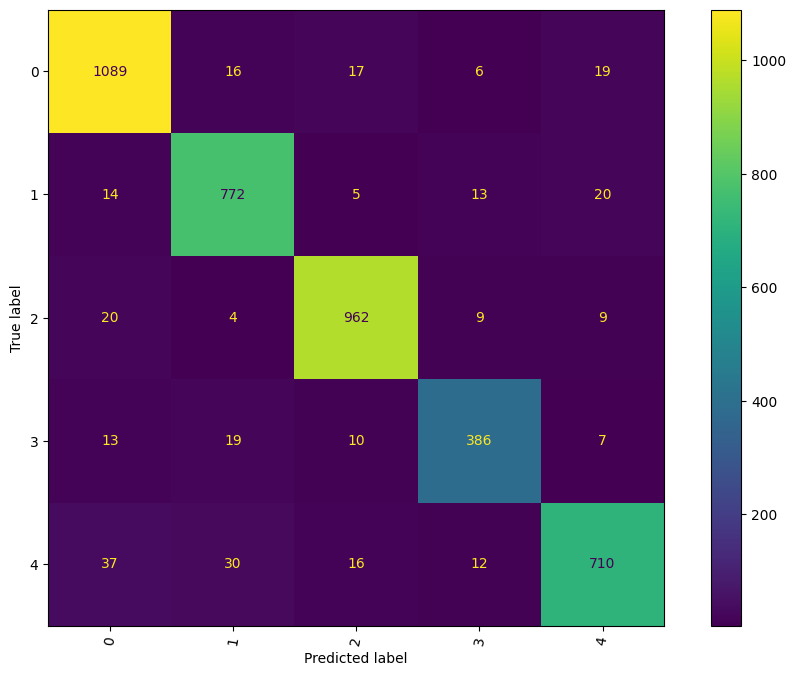

In [ ]:
# Logistic Regression with GridSearchCV

# logistic regression
log_reg = LogisticRegression()

# hyperparameter for Logistic Regression
log_params = {'C': [0.01, 1, 10],
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear','newton-cg','saga']
         }

# create gridsearch object
grid_search_log = grid_search(log_reg, folds, log_params, scoring=None)

# fit model
grid_search_log.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_log)

# Random Forest Classification Report
metric6=[]
display_classification_report(grid_search_log,metric6)

#### **The best model looks to be Logistic Regression with GridSearchCV**

In [ ]:
# raw complaint text
test_complaint= 'My Chase debit card stopped working in the middle of transaction. Money has not yet been debited again'

In [ ]:
# clean the raw text
test_complaint = prepare_text(test_complaint)
test_complaint = lemmatizer(test_complaint)
test_complaint = pos_extractor(test_complaint)
test_complaint

'chase debit card stop transaction money debit'

In [ ]:
# vectorize and tf-idf tranform
test = count_vect.transform([test_complaint])
test_tfidf = tfidf_transformer.transform(test)

In [ ]:
# predict
prediction=grid_search_log.predict(test_tfidf)
prediction

array([1])

In [ ]:
topic_mapping[prediction[1]]

'Credit card or prepaid card'